In [ ]:
import time
import random
import numpy as np
# import cupy as cp
import matplotlib.pyplot as plt
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

random.seed(154012)
np.random.seed(154012)
torch.manual_seed(154012)

In [ ]:
fc = 2.6 #2.6 GHz
bandwidth = 1e7 #10 MHz
temp = 40 + 273.15 # 40 celsius in kelvin
boltz = 1.381e-23
epsilon = 1e-7
row_bs = 4
col_bs = 4
mean_dist = 600
grid_width = mean_dist*(row_bs+1)
grid_height = mean_dist*(col_bs+1)

# if torch.cuda.is_available():
#   blackout_choices = cp.array([
#       [3*3600, 4*3600],
#       [6*3600, 4*3600],
#       [14*3600, 4*3600],
#       [19*3600, 4*3600],
#   ])
#   bs_loc = cp.mgrid[mean_dist: grid_width-mean_dist:mean_dist, mean_dist: grid_height-mean_dist:mean_dist]
#   bs_loc = bs_loc.reshape((2,-1)).T
#   bs_loc += mean_dist//10 - cp.random.randint(0, 2*mean_dist//10, bs_loc.shape)

#   bs_power = cp.array([40. for i in bs_loc])

#   print(bs_loc.shape)

#   bs_blackout = blackout_choices[cp.random.randint(0,3, (row_bs*col_bs))]


# else:
blackout_choices = np.array([
    [3*3600, 4*3600],
    [6*3600, 4*3600],
    [14*3600, 4*3600],
    [19*3600, 4*3600],
])
bs_loc = np.mgrid[mean_dist: grid_width:mean_dist, mean_dist: grid_height:mean_dist]
bs_loc = bs_loc.reshape((2,-1)).T
bs_loc += mean_dist//10 - np.random.randint(0, 2*mean_dist//10, bs_loc.shape)

bs_power = np.array([40. for i in bs_loc])

print(bs_loc.shape)

bs_blackout = blackout_choices[np.random.randint(0,3, (row_bs*col_bs))]

(16, 2)


In [ ]:
# class Environment():
#     def __init__(self, bs_loc, bs_power, bs_blackouts, max_power, min_power, n_actions, grid_width, grid_height, n_nearest):
#         self.bs_loc = bs_loc
#         self.bs_power = bs_power
#         self.electricity = np.zeros_like(bs_power)
#         self.bs_blackout_start = bs_blackouts[:,0]
#         self.bs_blackout_end = np.sum(bs_blackouts, axis=-1)
#         self.apply_blackouts(0)
#         self.max_power = max_power # in watt
#         self.min_power = min_power
#         self.n_actions = n_actions
#         self.grid_width = grid_width
#         self.grid_height = grid_height
#         self.points = np.mgrid[0:grid_width, 0:grid_height]
#         self.points = np.stack(self.points, axis=-1)
#         self.powers = self.power_grid(self.bs_loc, self.bs_power, self.points)
#         self.bit_rate = self.bit_rate_from_grid()
#         self.reward = self.get_reward()
#         self.actions = self.watt_to_dbm(np.linspace(min_power, max_power, n_actions))
#         self.n_nearest = min(n_nearest, bs_power.shape[0])
#         self.n_bs = bs_power.shape[0]
        
        
    
#     def get_input_dim(self):
#         return self.n_nearest*4 # after adding has electricity attrib 3 will be changed to 4
    
#     def get_output_dim(self):
#         return self.n_actions
    
#     def apply_blackouts(self, time):
#         self.electricity = (time>=self.bs_blackout_start) & (time<=self.bs_blackout_end)
    
#     def make_action(self, bs_index, action):
#         state = self.get_state(bs_index) 
#         self.bs_power[bs_index] = self.actions[action]
#         self.powers = self.power_grid(self.bs_loc, self.bs_power, self.points)
#         self.bit_rate = self.bit_rate_from_grid()
#         next_state = self.get_state(bs_index)
#         reward = self.get_reward()
#         return state, action, next_state, reward
        
#     def watt_to_dbm(self, watt):
#         return 10*np.log10(1000*watt)

#     def dbm_to_watt(self, dbm):
#         return np.power(10, dbm/10)/1000

#     def path_loss(self, distance, frequency=fc):
#     #     return 36.7*np.log10(distance) + 47.7 + 26*np.log10(frequency)
#         return 35*np.log10(distance) + 35.7

#     def power_grid(self, bs_loc, bs_power, points):
#         powers = []
#         for loc, power in zip(bs_loc, bs_power):
#             distance = np.linalg.norm(loc - points+epsilon, axis=-1)
#             powers.append(power - self.path_loss(distance))
#         return np.stack(powers, axis=-1)

#     def get_bit_rate_sinr(self, signal, interference, bandwidth=bandwidth, temp=temp):
#         return bandwidth*np.log10(1+ (signal/(interference + temp*boltz*bandwidth)))
    
#     def bit_rate_from_grid(self):
#         max_power = self.dbm_to_watt(self.powers.max(axis=-1))
#         interference_power = self.dbm_to_watt(self.powers).sum(axis=-1) - max_power
#         return self.get_bit_rate_sinr(max_power, interference_power)

#     def bit_rate_cost_function(self, b_rate):
#         total_points = 1
#         for i in b_rate.shape:
#             total_points *= i

#         under_1mb = b_rate<(1024**2)*8
#         under_1mb = under_1mb.sum()
#         min_speed = b_rate.min()/(1024*1024*8) #1MB
#         return 10*under_1mb/total_points + 1/(min_speed+epsilon)

#     def get_reward(self):
#         constant = 10
#         br_cost = self.bit_rate_cost_function(self.bit_rate)
#         print(self.electricity.shape)
#         print(self.dbm_to_watt(self.bs_power))
#         elec_cost = np.inner(self.electricity, self.dbm_to_watt(self.bs_power))
#         return 10 - br_cost - elec_cost
    
#     def get_state(self, bs_index):
#         x,y = self.bs_loc[bs_index]
#         powers = self.powers[np.round(x),np.round(y),:].reshape(-1)
#         indecies = np.argsort(powers)[::-1][:self.n_nearest]
#         bs_index_posistion = np.where(indecies == bs_index)[0]
        
#         if bs_index_posistion.size > 0:
#             indecies = np.delete(indecies, bs_index_posistion)
#             indecies = indecies[:self.n_nearest]
#         else:
#             indecies = indecies[:self.n_nearest-1]
            
#         bs_power = powers[bs_index]
#         state = np.array([powers[bs_index], self.electricity[bs_index], 0, 0])
#         nearest_powers = powers[np.array(indecies)]
#         nearest_elec = self.electricity[np.array(indecies)]
#         diff =  self.bs_loc[np.array(indecies)] - self.bs_loc[bs_index]
#         nearest_distances = np.linalg.norm(diff, axis=-1)
#         nearest_angles = np.arctan2(diff[:,1].reshape(-1), diff[:,0].reshape(-1))
        
#         return np.hstack((state, np.stack([nearest_powers, nearest_elec,
#                                            nearest_distances, nearest_angles], axis=-1).reshape(-1)))
    
#     def plot_bit_rate(self):
#         plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
#     def plot_log_bit_rate(self):
#         plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
#     def plot_power_grid(self):
#         plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
#     def plot_log_power_grid(self):
#         plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)

In [ ]:
class Environment():
    def __init__(self, bs_loc, bs_power, bs_blackouts, max_power, min_power, n_actions, grid_width, grid_height, n_nearest):
        self.bs_loc = bs_loc
        self.bs_power = bs_power
        self.electricity = np.zeros_like(bs_power) # 0 have electricity, 1 blackout
        self.bs_blackout_start = bs_blackouts[:,0]
        self.bs_blackout_end = np.sum(bs_blackouts, axis=-1)
        self.apply_blackouts(0)
        self.max_power = max_power # in watt
        self.min_power = min_power
        self.n_actions = n_actions
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.reward = self.get_reward()
        self.actions = self.watt_to_dbm(np.linspace(min_power, max_power, n_actions))
        self.n_nearest = min(n_nearest, bs_power.shape[0])
        self.n_bs = bs_power.shape[0]
        
    def baseline_action(self, bs_index):
        if self.electricity[bs_index]:
            self.make_action(bs_index, self.actions[0])
        else:
            self.make_action(bs_index, self.actions[-1])

    def get_input_dim(self):
        return self.n_nearest*4 # after adding has electricity attrib 3 will be changed to 4
    
    def get_output_dim(self):
        return self.n_actions
    
    def apply_blackouts(self, time):
        self.electricity = (time>=self.bs_blackout_start) & (time<=self.bs_blackout_end)
    
    def make_action(self, bs_index, action):
        state = self.get_state(bs_index) 
        self.bs_power[bs_index] = self.actions[action]
        # print(action, "-", self.bs_power)
        # self.powers = self.power_grid(self.bs_loc, self.bs_power, self.points)
        # self.bit_rate = self.bit_rate_from_grid()
        next_state = self.get_state(bs_index)
        reward = self.get_reward()
        return state, action, next_state, reward
        
    def watt_to_dbm(self, watt):
        return 10*np.log10(1000*watt)

    def dbm_to_watt(self, dbm):
        return np.power(10, dbm/10)/1000

    def path_loss(self, distance, frequency=fc):
    #     return 36.7*np.log10(distance) + 47.7 + 26*np.log10(frequency)
        return 35*np.log10(distance+1) + 35.7

    def power_grid(self, bs_loc, bs_power, points):
        powers = []
        for loc, power in zip(bs_loc, bs_power):
            distance = np.linalg.norm(loc - points+epsilon, axis=-1)
            powers.append(power - self.path_loss(distance))
        return np.stack(powers, axis=-1)

    def get_bit_rate_sinr(self, signal, interference, bandwidth=bandwidth, temp=temp):
        return bandwidth*np.log10(1+ (signal/(interference + temp*boltz*bandwidth)))
    
    def bit_rate_from_grid(self, powers):
        max_power = self.dbm_to_watt(powers.max(axis=-1))
        interference_power = self.dbm_to_watt(powers).sum(axis=-1) - max_power
        return self.get_bit_rate_sinr(max_power, interference_power)

    def bit_rate_cost_function(self, b_rate):
        total_points = self.grid_height * self.grid_width

        under_1mb = b_rate<(1024**2)*8
        under_1mb = under_1mb.sum()
        min_speed = b_rate.min()/(1024*1024*8) #1MB
        return 10*under_1mb/total_points , 1/(min_speed+epsilon)

    def get_reward(self):
        constant = 10
        br_cost = 0
        min_cost = 0
        for i in range(0, self.grid_width, 1000):
            for j in range(0, self.grid_height, 1000):
                points = np.mgrid[i:min(i+1000, grid_width), j:min(j+1000, grid_height)]
                points = np.stack(points, axis=-1)
                power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
                bit_rate = self.bit_rate_from_grid(power_grid)
                percentage, min_speed_cost = self.bit_rate_cost_function(bit_rate)
                br_cost += percentage
                min_cost = max(min_cost, min_speed_cost)
        # print(self.electricity.shape)
        # print(self.dbm_to_watt(self.bs_power))
        elec_cost = np.inner(self.electricity, self.dbm_to_watt(self.bs_power))
        return constant - br_cost - elec_cost - min_cost
    
    def get_state(self, bs_index):
        # get the base station location
        loc = self.bs_loc[bs_index]

        # get the recieved powers from each base station to the current base station
        powers = self.power_grid(self.bs_loc, self.bs_power, loc)
        # print("dbm")
        # print(powers)
        powers = self.dbm_to_watt(powers)
        # print("watt")
        # print(powers)

        # choose the base stations that give the most power to this location
        indecies = np.argsort(powers)[::-1][:self.n_nearest]

        # check if this base station is one of the base stations that gives the max power
        bs_index_posistion = np.where(indecies == bs_index)[0]
        

        # if the base station is one of them we remove it, that cause it is added later to the state
        # we do not we this value to be duplicated in the state
        if bs_index_posistion.size > 0:
            indecies = np.delete(indecies, bs_index_posistion)
            indecies = indecies[:self.n_nearest]
        else:
            indecies = indecies[:self.n_nearest-1]
            
        # get the power produce by the base station
        bs_power = powers[bs_index]
        self_power_norm = 1e3
        other_power_norm = 1e13

        # init state: rows represent base station 
        # in each row: recieved power, does it have electricity, distance from here, the angle
        state = np.array([bs_power*self_power_norm, self.electricity[bs_index], 0, 0])
        nearest_powers = other_power_norm*powers[np.array(indecies)]
        nearest_elec = self.electricity[np.array(indecies)]
        diff =  self.bs_loc[np.array(indecies)] - self.bs_loc[bs_index]
        nearest_distances = np.linalg.norm(diff, axis=-1)
        nearest_angles = np.arctan2(diff[:,1].reshape(-1), diff[:,0].reshape(-1))
        
        state = np.hstack((state, np.stack([nearest_powers, nearest_elec,
                                           nearest_distances, nearest_angles], axis=-1).reshape(-1)))

        # print(state)
        return state
    
    def plot_bit_rate(self):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        plt.contourf(points[:,:,0], points[:,:,1], bit_rate, 100, cmap = plt.cm.jet)
        
    def plot_log_bit_rate(self):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        plt.contourf(points[:,:,0], points[:,:,1], np.log(bit_rate + epsilon), 100, cmap = plt.cm.jet)

    def save_bit_rate_plot(self, index=None):
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        bit_rate = self.bit_rate_from_grid(power_grid)
        plt.contourf(points[:,:,0], points[:,:,1], bit_rate, 100, cmap = plt.cm.jet)
        if not index:
            plt.savefig('bitrate.png')
        else:
            name = "bitrate_{:06d}.png".format(index)
            plt.savefig(name)
        plt.contourf(points[:,:,0], points[:,:,1], np.log(bit_rate + epsilon), 100, cmap = plt.cm.jet)
        if not index:
            plt.savefig('log_bitrate.png')
        else:
            name = "log_bitrate_{:06d}.png".format(index)
            plt.savefig(name)
        
    def plot_watt_power_grid(self, index):
        if index < 0 or index >= self.n_bs:
            print("Invalid index")
            return
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        plt.contourf(points[:,:,0], points[:,:,1], self.dbm_to_watt(power_grid[:,:,index]), 100, cmap = plt.cm.jet)
        
    def plot_dbm_power_grid(self, index):
        if index < 0 or index >= self.n_bs:
            print("Invalid index")
            return
        points = np.meshgrid(np.linspace(0, self.grid_width, 1001), np.linspace(0, self.grid_height, 1001))
        points = np.stack(points, axis=-1)
        power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
        plt.contourf(points[:,:,0], points[:,:,1], power_grid[:,:,index], 100, cmap = plt.cm.jet)

In [ ]:
class EnvironmentGPU():
    def __init__(self, bs_loc, bs_power, bs_blackouts, max_power, min_power, n_actions, grid_width, grid_height, n_nearest):
        self.bs_loc = bs_loc
        self.bs_power = bs_power
        self.electricity = cp.zeros_like(bs_power) # 0 have electricity, 1 blackout
        self.bs_blackout_start = bs_blackouts[:,0]
        self.bs_blackout_end = cp.sum(bs_blackouts, axis=-1)
        self.apply_blackouts(0)
        self.max_power = max_power # in watt
        self.min_power = min_power
        self.n_actions = n_actions
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.reward = self.get_reward()
        self.actions = self.watt_to_dbm(cp.linspace(min_power, max_power, n_actions))
        self.n_nearest = min(n_nearest, bs_power.shape[0])
        self.n_bs = bs_power.shape[0]
        
    def baseline_action(self, bs_index):
        if self.electricity[bs_index]:
            self.make_action(bs_index, self.actions[0])
        else:
            self.make_action(bs_index, self.actions[-1])

    def get_icput_dim(self):
        return self.n_nearest*4 # after adding has electricity attrib 3 will be changed to 4
    
    def get_output_dim(self):
        return self.n_actions
    
    def apply_blackouts(self, time):
        self.electricity = (time>=self.bs_blackout_start) & (time<=self.bs_blackout_end)
    
    def make_action(self, bs_index, action):
        state = self.get_state(bs_index) 
        self.bs_power[bs_index] = self.actions[action]
        # print(action, "-", self.bs_power)
        # self.powers = self.power_grid(self.bs_loc, self.bs_power, self.points)
        # self.bit_rate = self.bit_rate_from_grid()
        next_state = self.get_state(bs_index)
        reward = self.get_reward()
        return state, action, next_state, reward
        
    def watt_to_dbm(self, watt):
        return 10*cp.log10(1000*watt)

    def dbm_to_watt(self, dbm):
        return cp.power(10, dbm/10)/1000

    def path_loss(self, distance, frequency=fc):
    #     return 36.7*cp.log10(distance) + 47.7 + 26*cp.log10(frequency)
        return 35*cp.log10(distance+1) + 35.7

    def power_grid(self, bs_loc, bs_power, points):
        powers = []
        for loc, power in zip(bs_loc, bs_power):
            distance = cp.linalg.norm(loc - points+epsilon, axis=-1)
            powers.append(power - self.path_loss(distance))
        return cp.stack(powers, axis=-1)

    def get_bit_rate_sinr(self, signal, interference, bandwidth=bandwidth, temp=temp):
        return bandwidth*cp.log10(1+ (signal/(interference + temp*boltz*bandwidth)))
    
    def bit_rate_from_grid(self, powers):
        max_power = self.dbm_to_watt(powers.max(axis=-1))
        interference_power = self.dbm_to_watt(powers).sum(axis=-1) - max_power
        return self.get_bit_rate_sinr(max_power, interference_power)

    def bit_rate_cost_function(self, b_rate):
        total_points = self.grid_height * self.grid_width

        under_1mb = b_rate<(1024**2)*8
        under_1mb = under_1mb.sum()
        min_speed = b_rate.min()/(1024*1024*8) #1MB
        return 10*under_1mb/total_points , 1/(min_speed+epsilon)

    def get_reward(self):
        constant = 10
        br_cost = 0
        min_cost = 0
        for i in range(0, self.grid_width, 1000):
            for j in range(0, self.grid_height, 1000):
                points = cp.mgrid[i:min(i+1000, grid_width), j:min(j+1000, grid_height)]
                points = cp.stack(points, axis=-1)
                power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
                bit_rate = self.bit_rate_from_grid(power_grid)
                percentage, min_speed_cost = self.bit_rate_cost_function(bit_rate)
                br_cost += percentage
                min_cost = max(min_cost, min_speed_cost)
        # print(self.electricity.shape)
        # print(self.dbm_to_watt(self.bs_power))
        elec_cost = cp.inner(self.electricity, self.dbm_to_watt(self.bs_power))
        return constant - br_cost - elec_cost - min_cost
    
    def get_state(self, bs_index):
        # get the base station location
        loc = self.bs_loc[bs_index]

        # get the recieved powers from each base station to the current base station
        powers = self.power_grid(self.bs_loc, self.bs_power, loc)
        powers = self.dbm_to_watt(powers)

        # choose the base stations that give the most power to this location
        indecies = cp.argsort(powers)[::-1][:self.n_nearest]

        # check if this base station is one of the base stations that gives the max power
        bs_index_posistion = cp.where(indecies == bs_index)[0]
        

        # if the base station is one of them we remove it, that cause it is added later to the state
        # we do not we this value to be duplicated in the state
        if bs_index_posistion.size > 0:
            indecies = cp.delete(indecies, bs_index_posistion)
            indecies = indecies[:self.n_nearest]
        else:
            indecies = indecies[:self.n_nearest-1]
            
        # get the power produce by the base station
        bs_power = powers[bs_index]
        self_power_norm = 1e3
        other_power_norm = 1e13

        # init state: rows represent base station 
        # in each row: recieved power, does it have electricity, distance from here, the angle
        state = cp.array([bs_power*self_power_norm, self.electricity[bs_index], 0, 0])
        nearest_powers = other_power_norm*powers[cp.array(indecies)]
        nearest_elec = self.electricity[cp.array(indecies)]
        diff =  self.bs_loc[cp.array(indecies)] - self.bs_loc[bs_index]
        nearest_distances = cp.linalg.norm(diff, axis=-1)
        nearest_angles = cp.arctan2(diff[:,1].reshape(-1), diff[:,0].reshape(-1))
        
        state = cp.hstack((state, cp.stack([nearest_powers, nearest_elec,
                                           nearest_distances, nearest_angles], axis=-1).reshape(-1)))

        # print(state)
        return state
    
    # def plot_bit_rate(self):
    #       points = cp.mgrid[i:min(i+1000, grid_width), j:min(j+1000, grid_height)]
    #       points = cp.stack(points, axis=-1)
    #       power_grid = self.power_grid(self.bs_loc, self.bs_power, points)
    #       bit_rate = self.bit_rate_from_grid(power_grid)
    #       plt.contourf(points[:,:,0], points[:,:,1], bit_rate, 100, cmap = plt.cm.jet)
        
    # def plot_log_bit_rate(self):
    #     plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
    # def plot_power_grid(self):
    #     plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)
        
    # def plot_log_power_grid(self):
    #     plt.contourf(self.points[:,:,0], self.points[:,:,1], self.bit_rate, 100, cmap = plt.cm.jet)

In [ ]:
class DQN(nn.Module): # ready
    def __init__(self, n_inputs, n_actions):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(in_features=n_inputs, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=n_actions)

    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

In [ ]:
Experience = namedtuple(
    "Experience", ("state", "action", "next_state", "reward")) # ready

In [ ]:
class ReplayMemory(): # ready
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [ ]:
class EpsilonGreedyStrategy(): # ready
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * np.exp(-1. * current_step * self.decay)

In [ ]:
class Agent():
    def __init__(self, strategy, num_actions):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action])
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1)

In [ ]:
class QValues():
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        values = target_net(next_states).max(dim=1)[0].detach()
        return values

In [ ]:
def get_moving_avg(values, period=25):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(
            dim=1).flatten(start_dim=0)
    else:
        moving_avg = torch.zeros_like(values)
    return moving_avg.numpy()

In [ ]:
def plot(values, moving_avg_period=25):
    plt.figure(2)
    plt.clf()
    plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(values)

    moving_avg = get_moving_avg(values, moving_avg_period)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period,
          "episode moving avg:", moving_avg[-1])
#     if is_ipython:
#         display.clear_output(wait=True)

In [ ]:
def extract_tensors(exps):
    batch = Experience(*zip(*exps))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.next_state)
    t4 = torch.cat(batch.reward)

    return (t1, t2, t3, t4)

In [ ]:
batch_size = 256
gamma = 0.9
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 1000
lr = 0.001
num_episodes = 1000
# print(bs_power.shape)
env = Environment(bs_loc, bs_power, bs_blackout,10, 0, 11, grid_width, grid_height, 4)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, env.get_output_dim())
memory = ReplayMemory(memory_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10


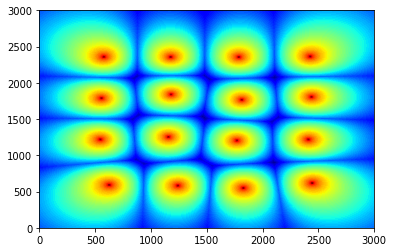

In [ ]:
env.save_bit_rate_plot()

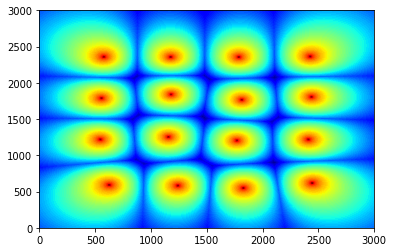

In [ ]:
env.save_bit_rate_plot( 1)

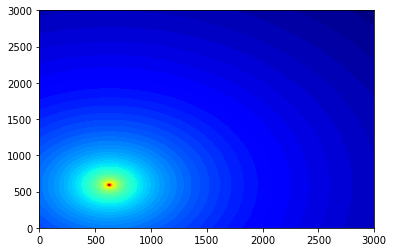

In [ ]:
env.plot_dbm_power_grid(0)

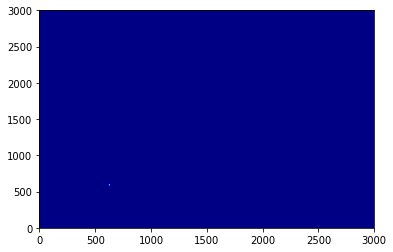

In [ ]:
env.plot_watt_power_grid(0)

In [ ]:
policy_net = DQN(env.get_input_dim(), env.get_output_dim())
target_net = DQN(env.get_input_dim(), env.get_output_dim())
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

In [ ]:
rewards_history = []
for episode in range(num_episodes):
    ep_timer = time.time()
    print("\n\nEPISODE_{:03d}:".format(episode+1))
    
    env.apply_blackouts(episode+1)
    
    for i in range(env.n_bs):
        timer = time.time()
        state = torch.tensor(env.get_state(i), dtype=torch.float).unsqueeze(0)

        action = agent.select_action(state, policy_net)
        _, action, next_state, reward = env.make_action(i, action)
        
        rewards_history.append(reward)

        reward = torch.tensor([reward], dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            exps = memory.sample(batch_size)
            states, actions, next_states, rewards = extract_tensors(exps)
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            optimizer.zero_grad()
            loss = F.smooth_l1_loss(
                current_q_values, target_q_values.unsqueeze(1))
            loss.backward()
            optimizer.step()

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print("\tBS_{:02d} DONE IN {} SECONDS, reward {}, action {}".format(i+1, time.time() - timer, reward[0], action[0]))

    print("EPISODE_{:03d} DONE IN {} SECONDS".format(episode+1, time.time() - ep_timer))

In [ ]:
plot(rewards_history)

In [ ]:
env.get_reward()

In [ ]:
class Critic(nn.Module):
    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, output_size)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, output_size)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

In [ ]:
# Taken from https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py

# class OUNoise(object):
#     def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
#         self.mu           = mu
#         self.theta        = theta
#         self.sigma        = max_sigma
#         self.max_sigma    = max_sigma
#         self.min_sigma    = min_sigma
#         self.decay_period = decay_period
#         self.action_dim   = action_space.shape[0]
#         self.low          = action_space.low
#         self.high         = action_space.high
#         self.reset()
        
#     def reset(self):
#         self.state = np.ones(self.action_dim) * self.mu
        
#     def evolve_state(self):
#         x  = self.state
#         dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
#         self.state = x + dx
#         return self.state
    
#     def get_action(self, action, t=0): 
#         ou_state = self.evolve_state()
#         self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
#         return np.clip(action + ou_state, self.low, self.high)

# THIS IS USED FOR CONTINUOUS ACTION SPACE AS NOISE FOR EXPLORATION VS EXPLOITATION

In [ ]:
batch_size = 256

env2 = Environment(bs_loc, bs_power, bs_blackout,10, 0, 11, grid_width, grid_height, 4)
strategy2 = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent2 = Agent(strategy2, env.get_output_dim())
memory2 = ReplayMemory(memory_size)

actor = Actor(env2.get_input_dim(), env2.get_output_dim())
actor_target = Actor(env2.get_input_dim(), env2.get_output_dim())
critic = Critic(env2.get_input_dim() + env2.get_output_dim(), env2.get_output_dim())
critic_target = Critic(env2.get_input_dim() + env2.get_output_dim(), env2.get_output_dim())

for target_param, param in zip(actor_target.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)
for target_param, param in zip(critic_target.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)


critic_criterion  = nn.MSELoss()
actor_optimizer  = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

tau=1e-2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10


In [ ]:
rewards_history2 = []
for episode in range(num_episodes):
    print("\n\nEPISODE_{:03d}:".format(episode+1))
    
    env2.apply_blackouts(episode+1)
    
    for i in range(env2.n_bs):
        timer = time.time()
        state = torch.tensor(env2.get_state(i), dtype=torch.float).unsqueeze(0)

        action = agent2.select_action(state, actor) 
        _, action, next_state, reward = env2.make_action(i, action)
        
        rewards_history2.append(reward) #

        reward = torch.tensor([reward], dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0)
        memory2.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory2.can_provide_sample(batch_size):
            exps = memory2.sample(batch_size)
            states, actions, next_states, rewards = extract_tensors(exps)

            actions_onehot = actions.numpy()
            actions_onehot = (np.arange(env2.get_output_dim()) == actions_onehot[:,None]).astype(np.float32)
            actions_onehot = torch.from_numpy(actions_onehot)
            
            Qvals = critic.forward(states, actions_onehot)
            next_actions = actor_target.forward(next_states)
            next_Q = critic_target.forward(next_states, next_actions.detach())
            Qprime = rewards.unsqueeze(1) + gamma * next_Q
            critic_loss = critic_criterion(Qvals, Qprime)

            # Actor loss
            policy_loss = -critic.forward(states, actor.forward(states)).mean()
            
            # update networks
            actor_optimizer.zero_grad()
            policy_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward() 
            critic_optimizer.step()

            for target_param, param in zip(actor_target.parameters(), actor.parameters()):
                target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))
        
            for target_param, param in zip(critic_target.parameters(), critic.parameters()):
                target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))

        print("\tBS_{:02d} DONE IN {} SECONDS, reward {}, action {}".format(i+1, time.time() - timer, reward[0], action[0]))



EPISODE_001:
	BS_01 DONE IN 4.791773796081543 SECONDS, reward -11.665447235107422, action 2
	BS_02 DONE IN 4.851381540298462 SECONDS, reward -11.79367446899414, action 5
	BS_03 DONE IN 4.80250096321106 SECONDS, reward -12.019174575805664, action 5
	BS_04 DONE IN 4.644041538238525 SECONDS, reward -34.238155364990234, action 2


EPISODE_002:
	BS_01 DONE IN 4.6948606967926025 SECONDS, reward -35.1815071105957, action 6
	BS_02 DONE IN 4.789889574050903 SECONDS, reward -34.076622009277344, action 2
	BS_03 DONE IN 4.754954099655151 SECONDS, reward -36.58517837524414, action 2
	BS_04 DONE IN 4.872875928878784 SECONDS, reward -12.713014602661133, action 6


EPISODE_003:
	BS_01 DONE IN 4.936152219772339 SECONDS, reward -11.874754905700684, action 1
	BS_02 DONE IN 4.784362077713013 SECONDS, reward -12.49435806274414, action 7
	BS_03 DONE IN 4.714529752731323 SECONDS, reward -12.345137596130371, action 7
	BS_04 DONE IN 4.835716009140015 SECONDS, reward -7.875134468078613, action 9


EPISODE_004

KeyboardInterrupt: ignored

In [ ]:
# plt.contourf(env.points[:,:,0], env.points[:,:,1], env.bit_rate, 100, cmap = plt.cm.jet)

In [ ]:
# print(env.bs_power)

In [ ]:
np.linspace(1000, 5000, 5)